# Introduction

## Setup

Please run ``conda env create -f cs182_hw8.yml`` to create the environment for this assignment. Then run ``bash download_data.sh`` to download the dataset.

## Problem Statement

In this assignment, you are going to train a neural network to summarize news articles.
Your neural network is going to learn from example, as we provide you with (article, summary) pairs.
We provide you with a **toy dataset** made of only articles about police related news.
Usual datasets can be 20x larger in size, but we have reduced it for computational purposes.

You will do this using a Transformer network, from the __[Attention is all you need](http://papers.nips.cc/paper/7181-attention-is-all-you-need.pdf)__ paper.
In this assignment you will:
- Learn to process text into sub-word tokens, to avoid fixed vocabulary sizes, and UNK tokens.
- Implement the key conceptual blocks of a Transformer.
- Use a Transformer to read a news article, and produce a summary.
- Perform operations on learned word-vectors to examine what the model has learned.

    
** Before you start **

You should read the Attention is all you need paper.
We are providing you with skeleton code for the Transformer, but there will have to implement 4 conceptual blocks of the transformer yourself:
-  AttentionQKV: the Query, Key, Value attention mechanism at the center of the Transformer
- MultiHeadAttention: the multiple heads that enable each input to attend at many places at once.
- PositionEmbedding: the sinusoid-based position embedding of the Transformer.
- Encoder & Decoder: The encoder (that reads inputs, such as news articles), the decoder (that produces the output summary, one token at a time)

For the most part, our implementation follows directly from the paper. There are two minor changes:
- We implement Multi-headed attention by generating single query, key, and value matrices, and then splitting it into multiple heads. (This is equivalent to the paper's implementation.)
- We apply layer normalization to the inputs to each block rather than the outputs.


# Library imports

In [1]:
# This cell autoreloads the notebook when you change you python file code.
# If you think the notebook did not reload, rerun this cell.
%load_ext autoreload
%autoreload 2

In [2]:
root_folder = ""
dataset_folder = "dataset/"

In [3]:
import os
import sys
sys.path.append(root_folder)
from transformer import Transformer
import sentencepiece as spm
import torch as th
from torch import nn
from torch.nn import functional as F
from torch import optim
import numpy as np
import json
import capita
import os
from transformer_utils import set_device
import gc
from utils import validate_to_array, model_out_to_list
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle as pkl

from transformer_kernel_attention import PerformerEncDec
from transformer_kernel_attention import gaussian_orthogonal_random_matrix, FastAttention
import torch
import torch as th
import random



device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(device)
set_device(device)

list_to_device = lambda th_obj: [tensor.to(device) for tensor in th_obj]

cuda


In [5]:
# Load the word piece model that will be used to tokenize the texts into
# word pieces with a vocabulary size of 10000
sp = spm.SentencePieceProcessor()
sp.Load(root_folder+"dataset/wp_vocab10000.model")

vocab = [line.split('\t')[0] for line in open(root_folder+"dataset/wp_vocab10000.vocab", "r")]
pad_index = vocab.index('#')

def pad_sequence(numerized, pad_index, to_length):
    pad = numerized[:to_length]
    padded = pad + [pad_index] * (to_length - len(pad))
    mask = [w != pad_index for w in padded]
    return padded, mask

# Building blocks of a Transformer


**TODO**:

In order to finish this section, you should get very small error <1e-7 on each of the 5 checks in this section.


The Transformer is split into 3 files: transformer_attention.py, transformer_utils.py and transformer.py

Each section below gives you directions and a way to verify your code works properly.

You do not need to modify the rest of the code provided, but should read it to understand overall architecture.

Our Transformer is built as a Pytorch model, a standard that is good for you to get accustomed to.



## (1) Implementing the Query-Key-Value Attention (AttentionQKV)

This part is located in AttentionQKV in transformer_attention.py. You must implement the call function of the class.
You will need to implement the mathematical procedure of AttentionQKV that is described in the [Attention is all you need paper](https://arxiv.org/pdf/1706.03762.pdf).

In [6]:
from transformer_attention import AttentionQKV

batch_size = 2
n_queries = 3
n_keyval = 5
depth_k = 2
depth_v = 2

with open(root_folder+"transformer_checks/attention_qkv_io.json", "r") as f:
    io = json.load(f)
    queries = th.tensor(io['queries'])
    keys = th.tensor(io['keys'])
    values = th.tensor(io['values'])
    expected_output  = th.tensor(io['output'])
    expected_weights = th.tensor(io['weights'])

attn_qkv = AttentionQKV()
output, weights = attn_qkv(queries, keys, values)
validate_to_array(model_out_to_list,((queries,keys,values),attn_qkv),'attentionqkv', root_folder)
print("Total error on the output:",th.sum(th.abs(expected_output-output)).item(), "(should be 0.0 or close to 0.0)")
print("Total error on the weights:",th.sum(th.abs(expected_weights-weights)).item(), "(should be 0.0 or close to 0.0)")


Total error on the output: 2.8312206268310547e-07 (should be 0.0 or close to 0.0)
Total error on the weights: 2.849847078323364e-07 (should be 0.0 or close to 0.0)


/home/cleverctz/anaconda3/envs/deepl/lib/python3.8/site-packages/numpy/lib/npyio.py:501: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


### Visualizing the AttentionQKV

(a) Visualize attention weights for randomly-chosen Q, K, and V matrices. Would you expect weights to sum to 1 if we sum over the queries dimenstion, or over the keys dimension? Confirm this below, and explain why it intuitively makes sense.

(b) In high-dimensional space, randomly chosen vectors are nearly orthogonal to each other. This means that even at initialization is is fairly easy to learn a query which can attend strongly to a particular key. Visualize the attention weights below. In this example, Q is a random matrix, K = Q, and V is a lower-triangular matrix. Explain why we see the attention weights and outputs we do.

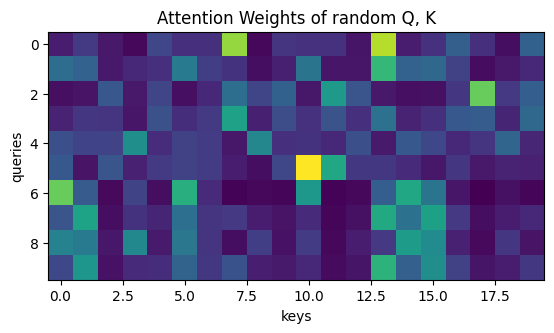

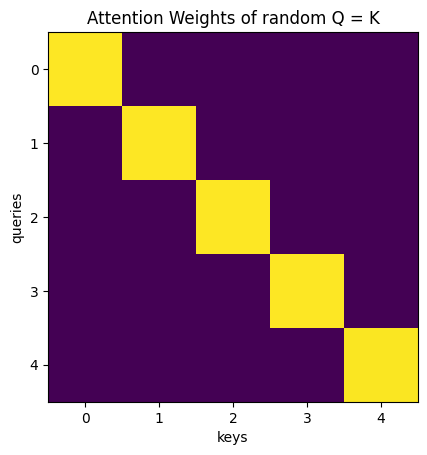

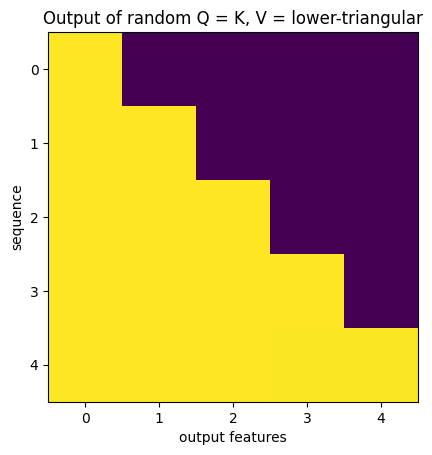

[[1.0000000e+00 1.5857114e-03 5.5087922e-04 2.3924367e-04 1.7629772e-04]
 [1.0000001e+00 9.9947339e-01 2.0565992e-04 1.6478877e-04 9.3055503e-05]
 [9.9999988e-01 9.9975669e-01 9.9969399e-01 3.2265217e-04 2.3583879e-04]
 [9.9999994e-01 9.9992645e-01 9.9976188e-01 9.9963200e-01 4.8829184e-05]
 [1.0000000e+00 9.9869508e-01 9.9734169e-01 9.9510509e-01 9.9479550e-01]]


In [24]:
# Visualizing attention weights on random data
queries = th.randn(1, 10, 3)
keys = th.randn(1, 20, 3)
values = th.randn(1, 20, 3)
output, weights = attn_qkv(queries, keys, values)
plt.imshow(weights[0].detach().numpy())
plt.xlabel("keys")
plt.ylabel("queries")
plt.title('Attention Weights of random Q, K')
plt.show()

sum_to_1_dim = -1 # TODO: remove for student version
assert th.allclose(weights.sum(dim=sum_to_1_dim), th.ones_like(weights.sum(dim=sum_to_1_dim)))


# Confirm that if K = Q for long random inputs, then the weights are close to the identity
queries = keys = th.randn(1, 5, 100)  # (batch, seq_len, depth_k)
# Values will be a lower-triangular matrix with 1s on the diagonal
values = th.tril(th.ones(5, 5)).unsqueeze(0).repeat(1, 1, 1)  # (batch, seq_len, depth_v)

output, weights = attn_qkv(queries, keys, values)
# Plot the weights and the output
plt.imshow(weights[0].detach().numpy())
plt.xlabel("keys")
plt.ylabel("queries")
plt.title('Attention Weights of random Q = K')
plt.show()
plt.xlabel("output features")
plt.ylabel('sequence')
plt.title('Output of random Q = K, V = lower-triangular')
plt.imshow(output[0].detach().numpy())
plt.show()
print(output[0].detach().numpy())


## (2) Implementing Multi-head attention

This part is located in the class MultiHeadProjection in transformer_attention.py.
You must implement the call, \_split_heads, and \_combine_heads functions.

**Procedure**

The objective is to leverage the AttentionQKV class you already wrote.

Your input are the queries, keys, values as 3-d tensors (batch_size, sequence_length, feature_size).

Split them into 4-d tensors (batch_size, n_heads, sequence_length, new_feature_size). Where:
$$feature\_size = n\_heads * new_{feature\_size}.$$

You can then feed the split qkv to your implemented AttentionQKV, which will treat each head as an independent attention function.

Then the output must be combined back into a 3-d tensor.
You can test the validity of your implementation in the cell below.

In [38]:
from transformer_attention import MultiHeadProjection

batch_size = 2
n_queries = 3
n_heads = 4
n_keyval = 5
depth_k = 8
depth_v = 8

with open(root_folder+"transformer_checks/multihead_io.json", "r") as f:
    io = json.load(f)
    queries = th.tensor(io['queries'])
    keys = th.tensor(io['keys'])
    values = th.tensor(io['values'])
    expected_output  = th.tensor(io['output'])

mhp = MultiHeadProjection(n_heads, (depth_k,depth_v))
multihead_output = mhp((queries, keys, values))
validate_to_array(model_out_to_list,(((queries,keys,values),),mhp),'multihead', root_folder)
print("Total error on the output:",th.sum(th.abs(expected_output-multihead_output)).item(), "(should be 0.0 or close to 0.0)")

Total error on the output: 1.5934929251670837e-06 (should be 0.0 or close to 0.0)


## (3) Position Embedding 

You must implement the FeedForward and PositionEmbedding classes in transformer.py.


The cell below helps you verify the validity of your implementation


In [39]:
from transformer import PositionEmbedding

batch_size = 2
sequence_length = 3
dim = 4

with open(root_folder+"transformer_checks/position_embedding_io.json", "r") as f:
    io = json.load(f)
    inputs = th.tensor(io['inputs'])
    expected_output  = th.tensor(io['output'])

pos_emb = PositionEmbedding(dim)
(inputs,expected_output,pos_emb) = list_to_device((inputs,expected_output,pos_emb))
output_t = pos_emb(inputs)
validate_to_array(model_out_to_list,((inputs,),pos_emb),'position_embedding', root_folder)
print("Total error on the output:",th.sum(th.abs(expected_output-output_t)).item(), "(should be 0.0 or close to 0.0)")

Total error on the output: 2.980232238769531e-07 (should be 0.0 or close to 0.0)


### Visualizing the Position Embedding

Run the cells below to visualize the position embedding and make sure you understand how it works and how it enables us to attend to relative positions.

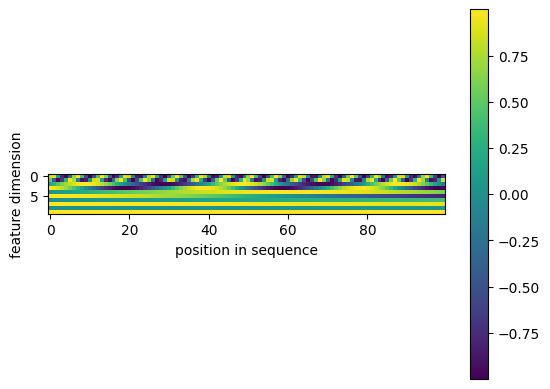

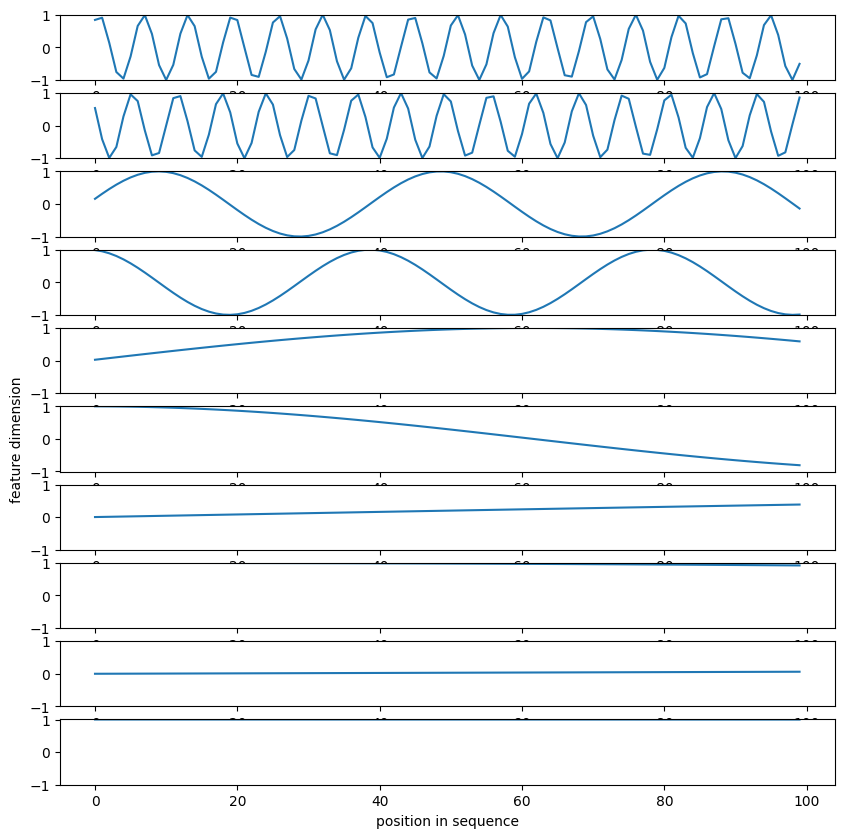

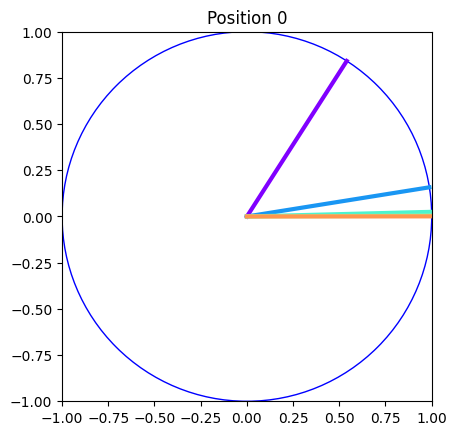

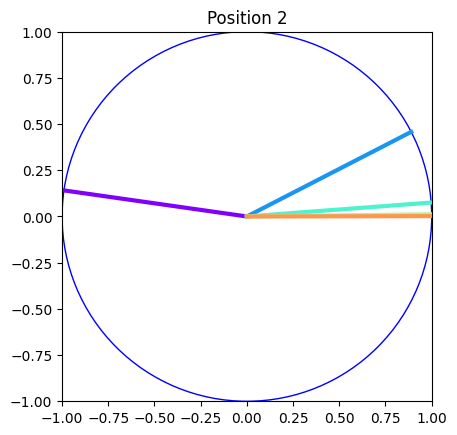

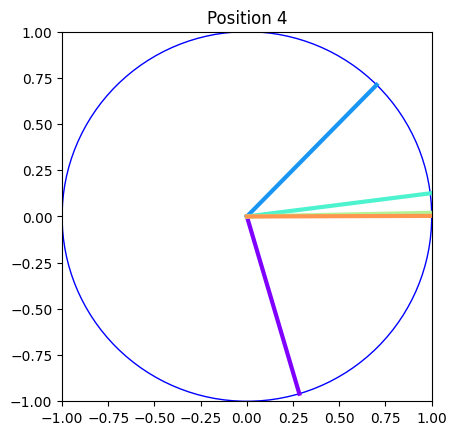

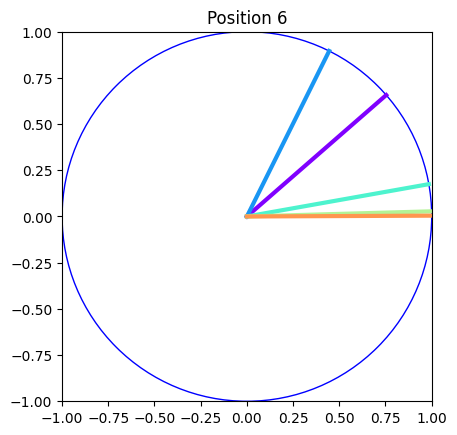

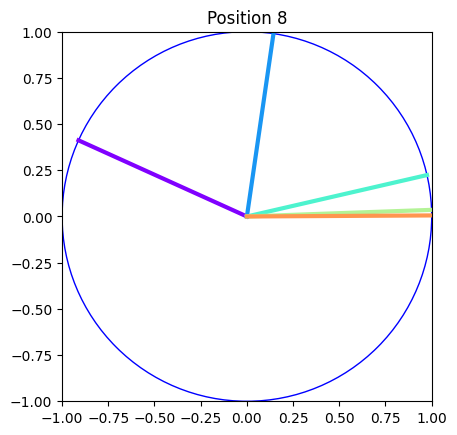

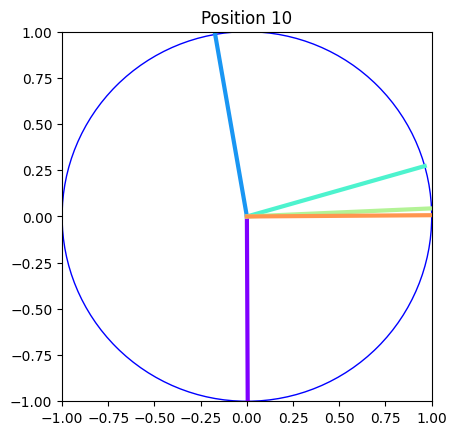

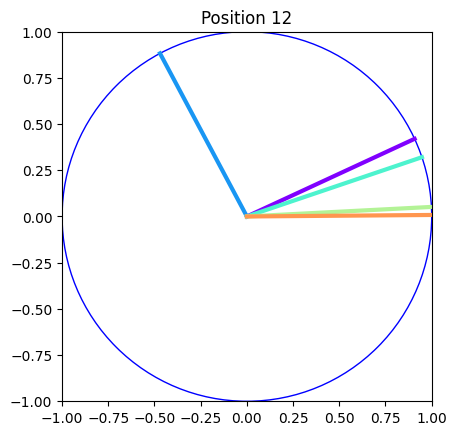

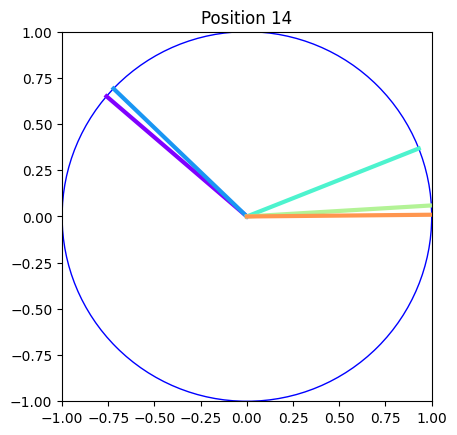

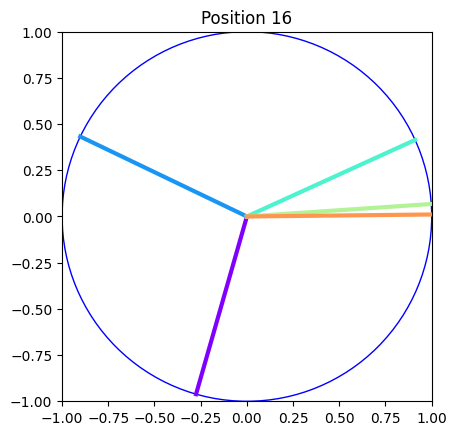

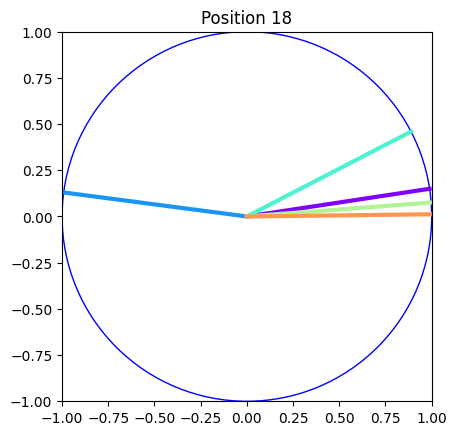

In [40]:
# To highlight the effect of the position embedding, we will make the sequence items all zeros
dim = 10
inputs_zeros = th.zeros(1, 100, dim).to(device)
pos_emb = PositionEmbedding(dim)
output = pos_emb(inputs_zeros)

plt.imshow(output[0].T.detach().cpu().numpy())
plt.xlabel("position in sequence")
plt.ylabel("feature dimension")
plt.colorbar()
plt.show()


# Print the positional embeddings on vertically stacked plots
fig, axs = plt.subplots(dim, 1, figsize=(10, 10))
for i in range(dim):
    axs[i].plot(output[0, :, i].detach().cpu().numpy())
    axs[i].set_ylim(-1.001, 1.001)
axs[-1].set_xlabel('position in sequence')
axs[5].set_ylabel('feature dimension')
plt.show()

# Alternatively, you can think of positional embeddings as a clock
# Each pair of sine/cosine elements is a clock hand
# The clock hands move at different speeds.
# (Optional) consider using a library like moviepy to convert these
# visualizations into a movie.
skip = 2
for i in range(0, 10 * skip, skip):
    plt.title(f"Position {i}")
    pos_enc = output[0, i, :].detach().cpu().numpy()
    
    for feat in range(0, 10, 2):
        y_coord = pos_enc[feat]
        x_coord = pos_enc[feat + 1]
        plt.plot([0, x_coord], [0, y_coord], linewidth=3, c=plt.cm.rainbow(feat/10))
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.gca().add_artist(plt. Circle((0,0), 1, color='b', fill=False))
    plt.show()

### Using positional embedding for relative attention

Run the cells below to see how you can use this positional encoding scheme to generate queries which attend to relevant positions. Here, we generate a query which attends to the previous position.


(c) (Optional) Derive why the transformation matrix used in the cell below attends to the previous position - i.e. derive a matrix $M \in \mathbb{R}^{d \times d}$ such that $p_{t-1} = M p_t$, where $p_t$ is the $d$-dimensional positional encoding for timestep $t$.

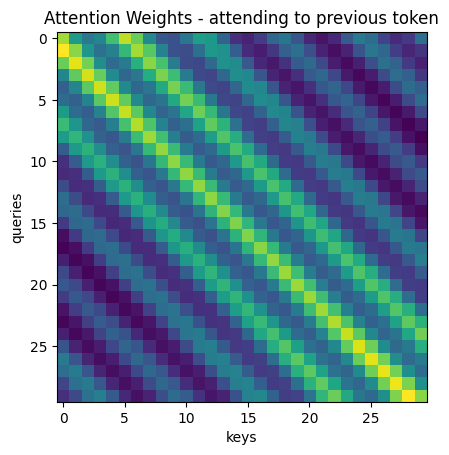

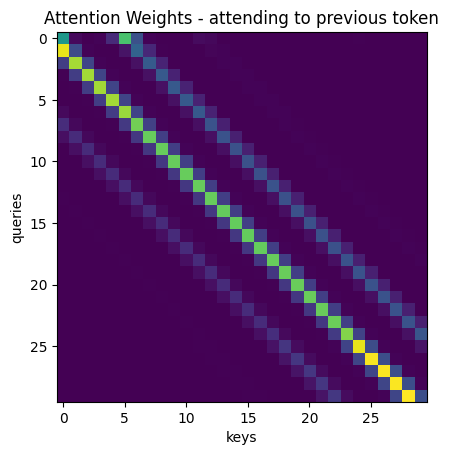

In [41]:
# Positional encoding
dim = 10
# To highlight the effect of the position embedding, we will make the sequence items all zeros
inputs_zeros = th.zeros(1, 30, dim).to(device)
pos_emb = PositionEmbedding(dim)
keys = queries = values = pos_emb(inputs_zeros) 

# Create a transformation matrix to make the positional encoding attend to the previous position
query_matrix = th.zeros(dim, dim).to(device)
for i in range(0, dim, 2): # Consider each sine/cosine pair together.
    w_k = th.tensor(1 / (10000 ** ((2 * i) / dim)))
    # Use properties of sines and cosines to create a transformation matrix
    m_matrix = th.tensor([[th.cos(w_k), th.sin(w_k)], [-th.sin(w_k), th.cos(w_k)]]).to(device)
    query_matrix[i:i+2, i:i+2] = m_matrix

queries = th.matmul(queries, query_matrix)

attn_qkv = AttentionQKV()
output, weights = attn_qkv(queries, keys, values)

# Plot the weights and the output
plt.imshow(weights[0].detach().cpu().numpy())
plt.xlabel("keys")
plt.ylabel("queries")
plt.title('Attention Weights - attending to previous token')
plt.show()

# We can see that the attention weights are highest for the previous position
# However, they are also high for many other positions.
# We can make the pattern clearer by multiplying the queries by a constant

queries *= 10
attn_qkv = AttentionQKV()
output, weights = attn_qkv(queries, keys, values)

# Plot the weights and the output
plt.imshow(weights[0].detach().cpu().numpy())
plt.xlabel("keys")
plt.ylabel("queries")
plt.title('Attention Weights - attending to previous token')
plt.show()

## (4) Transformer Encoder / Transformer Decoder

You now have all the blocks needed to implement the Transformer.
For this part, you have to fill in 3 classes in the transformer.py file: TransformerEncoderBlock, TransformerDecoderBlock, and TransformerFeedForward.
The code below will verify the accuracy of each block

In [42]:
from transformer import TransformerEncoderBlock

batch_size = 2
sequence_length = 5
hidden_size = 6
filter_size = 12
n_heads = 2

with open(root_folder+"transformer_checks/transformer_encoder_block_io_new.json", "r") as f:
    io = json.load(f)
    inputs = th.tensor(io['inputs'])
    expected_output = th.tensor(io['output'])
enc_block = TransformerEncoderBlock(input_size=6, n_heads=n_heads, filter_size=filter_size, hidden_size=hidden_size)
# th.save(enc_block.state_dict(),root_folder+"transformer_checks/transformer_encoder_block")
enc_block.load_state_dict(th.load(root_folder+"transformer_checks/transformer_encoder_block"))
(inputs,expected_output,enc_block) = list_to_device((inputs,expected_output,enc_block))
output_t = enc_block(inputs)
validate_to_array(model_out_to_list,((inputs,),enc_block),'encoder_block', root_folder)
print("Total error on the output:",th.sum(th.abs(expected_output-output_t)).item(), "(should be 0.0 or close to 0.0)")

Total error on the output: 5.103647708892822e-06 (should be 0.0 or close to 0.0)


In [43]:
from transformer import TransformerDecoderBlock
batch_size = 2
encoder_length = 5
decoder_length = 3
hidden_size = 6
filter_size = 12
n_heads = 2

with open(root_folder+"transformer_checks/transformer_decoder_block_io_new.json", "r") as f:
    io = json.load(f)
    decoder_inputs = th.tensor(io['decoder_inputs'])
    encoder_output = th.tensor(io['encoder_output'])
    expected_output = th.tensor(io['output'])

dec_block = TransformerDecoderBlock(input_size=6, n_heads=n_heads, filter_size=filter_size, hidden_size=hidden_size)
dec_block.load_state_dict(th.load(root_folder+"transformer_checks/transformer_decoder_block"))
(decoder_inputs,encoder_output,expected_output,dec_block) = list_to_device((decoder_inputs,encoder_output,expected_output,dec_block))
output_t = dec_block(decoder_inputs, encoder_output)
validate_to_array(model_out_to_list,((decoder_inputs, encoder_output),dec_block),'decoder_block', root_folder)
print("Total error on the output:",th.sum(th.abs(expected_output-output_t)).item(), "(should be 0.0 or close to 0.0)")


Total error on the output: 3.3676624298095703e-06 (should be 0.0 or close to 0.0)


## (5) Training the Model

The final high-level function that pieces it all together has been implemented for you in the `transformer.py` file.

The block below verifies your overall implementation is correct.

In [44]:
from transformer import Transformer

batch_size = 2
vocab_size = 11
n_layers = 3
n_heads = 4
d_model = 8
d_filter = 16
input_length = 5
output_length = 3

with open(root_folder+"transformer_checks/transformer_io_new.json", "r") as f:
    io = json.load(f)
    enc_input = th.tensor(io['enc_input'])
    dec_input = th.tensor(io['dec_input'])
    enc_mask = th.tensor(io['enc_mask'])
    dec_mask = th.tensor(io['dec_mask'])
    expected_output = th.tensor(io['output'])
transformer = Transformer(vocab_size=vocab_size, n_layers=n_layers, n_heads=n_heads, d_model=d_model, d_filter=d_filter)
transformer.load_state_dict(th.load(root_folder+"transformer_checks/transformer"))
(enc_input,dec_input,enc_mask,dec_mask,expected_output,transformer) \
    = list_to_device((enc_input,dec_input,enc_mask,dec_mask,expected_output,transformer))
output_t = transformer(enc_input, target_sequence=dec_input, encoder_mask=enc_mask, decoder_mask=dec_mask)
validate_to_array(model_out_to_list, ((enc_input, dec_input, enc_mask, dec_mask),transformer),'transformer', root_folder)
print("Total error on the output:",th.sum(th.abs(expected_output-output_t)).item(), "(should be 0.0 or close to 0.0)")

Total error on the output: 6.020069122314453e-05 (should be 0.0 or close to 0.0)


Your objective is to train the Language on the dataset you are provided to reach a **validation loss <= 4.5**

Careful: we will be testing this loss on an unreleased test set, so make sure to evaluate properly on a validation set and not overfit.

You must save the model you want us to test under: models/final_transformer_summarization (the .index, .meta and .data files)

(If you are unable to reach this loss because you don't have access to a GPU, please run for as long as you can. We will look at the trend in the loss curves rather than the final loss.)

**Advice**:
- It should be possible to attain validation loss <= 4.5 with the model dimensions we've specified (n_layers=6, d_model=104, d_filter=416), but you can tune these hyperparameters. Increasing d_model will yield better model, at the cost of longer training time.
- You should try tuning the learning rate, as well as what optimizer you use.
- You might need to train for a while (20 mins up to 2 hours depending on the quality of GPU available) to obtain our expected loss. Remember to tune your hyperparameters first, once you find ones that work well, let it train for longer.


In [45]:
with open(root_folder+"dataset/summarization_dataset_preprocessed.json", "r") as f:
    dataset = json.load(f)

# We load the dataset, and split it into 2 sub-datasets based on if they are training or validation.
# Feel free to split this dataset another way, but remember, a validation set is important, to have an idea of 
# the amount of overfitting that has occurred!

d_train = [d for d in dataset if d['cut'] == 'training']
d_valid = [d for d in dataset if d['cut'] == 'evaluation']

len(d_train), len(d_valid)

(61055, 1558)

In [46]:
# An example (article, summary) pair in the training data:

print(d_train[145]['story'])
print("=======================\n=======================")
print(d_train[145]['summary'])

Tbilisi, Georgia (CNN)Police have shot and killed a white tiger that killed a man Wednesday in Tbilisi, Georgia, a Ministry of Internal Affairs representative said, after severe flooding allowed hundreds of wild animals to escape the city zoo. 
The tiger attack happened at a warehouse in the city center. The animal had been unaccounted for since the weekend floods destroyed the zoo premises.
The man killed, who was 43, worked in a company based in the warehouse, the Ministry of Internal Affairs said. Doctors said he was attacked in the throat and died before reaching the hospital. 
Experts are still searching the warehouse, the ministry said, adding that earlier reports that the tiger had injured a second man were unfounded. 
The zoo administration said Wednesday that another tiger was still missing. It was unable to confirm if the creature was dead or had escaped alive.
Georgian Prime Minister Irakli Garibashvili apologized to the public, saying he had been misinformed by the zoo's ma

Similarly to the previous assignment, we create a function to get a random batch to train on, given a dataset.

In [47]:
def build_batch(dataset, batch_size):
    indices = list(np.random.randint(0, len(dataset), size=batch_size))
    
    batch = [dataset[i] for i in indices]
    batch_input = np.array([a['input'] for a in batch])
    batch_input_mask = np.array([a['input_mask'] for a in batch])
    batch_output = np.array([a['output'] for a in batch])
    batch_output_mask = np.array([a['output_mask'] for a in batch])
    
    return batch_input, batch_input_mask, batch_output, batch_output_mask

We now instantiate the Transformer with our sets of hyperparameters specific to the task of summarization.
In summarization, we are going to go from documents with up to 400 words, to documents with up to 100 words.
The vocabulary size is set for you, and is of 10,000 words (we are using WordPieces, [here is a paper about subword encoding](http://aclweb.org/anthology/P18-1007), if you are interested).

In [48]:
class TransformerTrainer(nn.Module):
    def __init__(self, vocab_size, d_model, input_length, output_length, n_layers, d_filter, dropout=0, learning_rate=1e-3, performer=False):
        super().__init__()
        self.performer = performer
        if performer:
            self.model = PerformerEncDec(num_tokens=vocab_size, max_seq_len=max(output_length, input_length), depth=n_layers, heads=n_heads, dim=d_model, ff_mult=d_filter//d_model, dim_head=d_model//n_heads)
        else:
            self.model = Transformer(vocab_size=vocab_size, d_model=d_model, n_layers=n_layers, d_filter=d_filter)

        # Summarization loss
        criterion = nn.CrossEntropyLoss(reduce='none')
        self.loss_fn = lambda pred,target,mask: (criterion(pred.permute(0,2,1),target)*mask).sum()/mask.sum()
        self.learning_rate = learning_rate
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
    
    def forward(self,batch,optimize=True):
        target,mask = batch['target_sequence'],batch['decoder_mask']
        if self.performer:
            _, pred_logits = self.model(**batch)
            target = target[:,1:]
            mask = mask[:, 1:]
        else:
            pred_logits = self.model(**batch)
        
        loss = self.loss_fn(pred_logits,target,mask)
        accuracy = (th.eq(pred_logits.argmax(dim=2,keepdim=False),target).float()*mask).sum()/mask.sum()
        
        if optimize:
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
                
        return loss, accuracy

In [49]:
# Dataset related parameters
vocab_size = len(vocab)
ilength = 400 # Length of the article
olength  = 100 # Length of the summaries

# Model related parameters, feel free to modify these.
n_layers = 6
d_model  = 160
d_filter = 4*d_model
batch_size = 16

dropout = 0
learning_rate = 1e-3
trainer = TransformerTrainer(vocab_size, d_model, ilength, olength, n_layers, d_filter, dropout)
model_id = 'test1'
os.makedirs(root_folder+'models/summarization/',exist_ok=True)

# Understanding how parameters are distributed in the Transformer

Run the cell below with a few different values for each parameter, and observe how it changes the number of parameters stored in the model.

(d) In this model, the encoder and decoder share the same dimensions. Is this necessary, or could we choose to make them different?

In [50]:
model = Transformer(vocab_size=vocab_size, d_model=d_model, n_layers=n_layers, d_filter=d_filter)
model = trainer.model
# Print the number of parameters in the model
print("Overall parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))
print("Parameters in the encoder:", sum(p.numel() for p in model.encoder.parameters() if p.requires_grad))
print("Parameters in the decoder:", sum(p.numel() for p in model.decoder.parameters() if p.requires_grad))
print("Parameters in attention", sum(p.numel() for name, p in model.named_parameters() if p.requires_grad and 'attention' in name))
print("Parameters in feedforward", sum(p.numel() for name, p in model.named_parameters() if p.requires_grad and 'feed_forward' in name))
print("Parameters in normalization", sum(p.numel() for name, p in model.named_parameters() if p.requires_grad and 'norm' in name))
print("Parameters in embeddings", sum(p.numel() for name, p in model.named_parameters() if p.requires_grad and 'embedding' in name))

Overall parameters: 5933440
Parameters in the encoder: 3455680
Parameters in the decoder: 4077760
Parameters in attention 1854720
Parameters in feedforward 2471040
Parameters in normalization 11520
Parameters in embeddings 1600000


In [51]:
def get_valid_acc(trainer, d_valid):
    trainer.model = model.eval()
    losses = []
    accuracies = []
    for i in tqdm(range(100)):
        batch = build_batch(d_valid, 1)
        # Build the feed-dict connecting placeholders and mini-batch
        batch_input, batch_input_mask, batch_output, batch_output_mask = [th.tensor(tensor) for tensor in batch]
        batch_input, batch_input_mask, batch_output, batch_output_mask \
                    = list_to_device([batch_input, batch_input_mask, batch_output, batch_output_mask])
        batch = {'source_sequence': batch_input, 'target_sequence': batch_output,
                'encoder_mask': batch_input_mask, 'decoder_mask': batch_output_mask}
        valid_loss, accuracy = trainer(batch,optimize=False)
        losses.append(float(valid_loss.cpu().item()))
        accuracies.append(float(accuracy.cpu().item()))
    trainer.model = model.train()
    return np.mean(losses), np.mean(accuracies)

In [52]:
# Skeleton code, as in the previous notebook.
# Write code training code and save your best performing model on the
# validation set. We will be testing the loss on a held-out test dataset.
from tqdm import tqdm

trainer.to(device)
trainer.model.train()
losses,accuracies = [],[]
val_loss_list, val_acc_list = [], []
train_loss_list, train_acc_list = [], []
val_loss = val_acc = -1
t = tqdm(range(int(1e4)+1)) # Adjust the number of iterations up to get better results or down to iterate faster

for i in t:
    # Create a random mini-batch from the training dataset
    batch = build_batch(d_train, batch_size)
    # Build the feed-dict connecting placeholders and mini-batch
    batch_input, batch_input_mask, batch_output, batch_output_mask = [th.tensor(tensor) for tensor in batch]
    batch_input, batch_input_mask, batch_output, batch_output_mask \
                = list_to_device([batch_input, batch_input_mask, batch_output, batch_output_mask])
    batch = {'source_sequence': batch_input, 'target_sequence': batch_output,
            'encoder_mask': batch_input_mask, 'decoder_mask': batch_output_mask}

    # Obtain the loss. Be careful when you use the train_op and not, as previously.
    train_loss, accuracy = trainer(batch)
    losses.append(train_loss.item()),accuracies.append(accuracy.item())
    if i % 10 == 0:
        t.set_description(f"Itr: {i} Train Loss: {np.mean(losses[-10:])} Train Acc: {np.mean(accuracies[-10:])}, Val Loss: {val_loss} Val Acc: {val_acc}")
    if i % 100 == 0:
        save_dict = dict(
            kwargs = dict(
                vocab_size=vocab_size,
                d_model=d_model,
                n_layers=n_layers, 
                d_filter=d_filter
            ),
            model_state_dict = trainer.model.state_dict(),
            notes = ""
        )
        th.save(save_dict, root_folder+f'models/summarization/model_{model_id}.pt')
        val_loss, val_acc = get_valid_acc(trainer, d_valid)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)
        train_loss_list.append(np.mean(losses[-10:]))
        train_acc_list.append(np.mean(accuracies[-10:]))
        import pickle as pkl
        # Save the losses and accuracies
        with open(root_folder+f'models/summarization/model_{model_id}losses.pkl', 'wb') as f:
            pkl.dump({'train_loss': train_loss_list, 'train_accuracy': train_acc_list, 'val_loss': val_loss_list, 'val_acc': val_acc_list}, f)

100%|██████████| 100/100 [00:03<00:00, 26.85it/s]c: 0.3513532429933548, Val Loss: 4.213308468163014 Val Acc: 0.35314940005540846: 100%|█████████▉| 10000/10001 [52:33<00:00,  3.25it/s]
Itr: 10000 Train Loss: 3.258156728744507 Train Acc: 0.3513532429933548, Val Loss: 4.213308468163014 Val Acc: 0.35314940005540846: 100%|██████████| 10001/10001 [52:37<00:00,  3.17it/s]


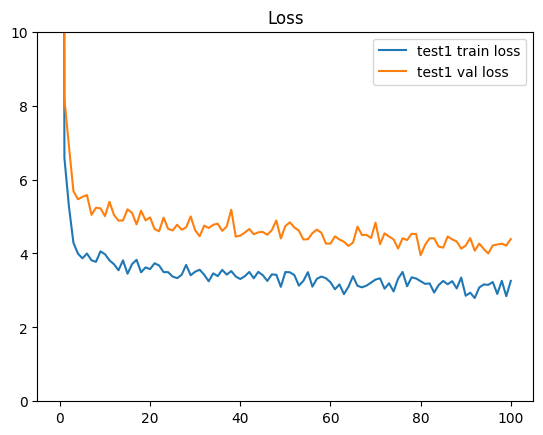

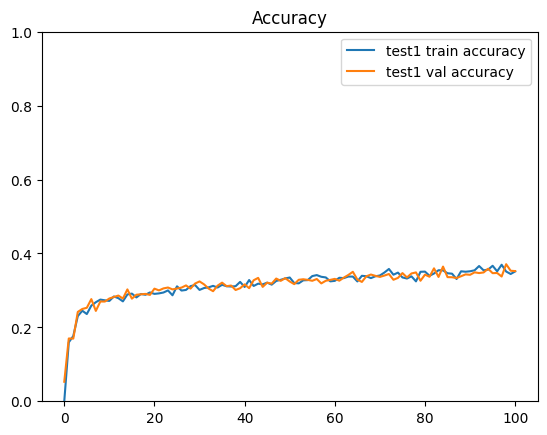

In [53]:
# Load and plot the losses
model_ids_list = ['test1']  # Fill this with the list of models you want to plot. After you run the performer model in the final cell, you can add it to the list.

loss_acc_dicts = {}

for model_id in model_ids_list:
    with open(root_folder+f'models/summarization/model_{model_id}losses.pkl', 'rb') as f:
        loss_acc_dicts[model_id] = pkl.load(f)

# Plot the losses
for model_id in model_ids_list:
    plt.plot(loss_acc_dicts[model_id]['train_loss'], label=f'{model_id} train loss')
    plt.plot(loss_acc_dicts[model_id]['val_loss'], label=f'{model_id} val loss')
plt.legend()
plt.ylim(0, 10)
plt.title('Loss')
plt.show()
    
# Plot the accuracies
for model_id in model_ids_list:
    plt.plot(loss_acc_dicts[model_id]['train_accuracy'], label=f'{model_id} train accuracy')
    plt.plot(loss_acc_dicts[model_id]['val_acc'], label=f'{model_id} val accuracy')
plt.legend()
plt.ylim(0, 1)
plt.title('Accuracy')
plt.show()


### Visualizing Masks

(e) Run the notebook cell below which visualizes attention maps, and explain the patterns of the masks

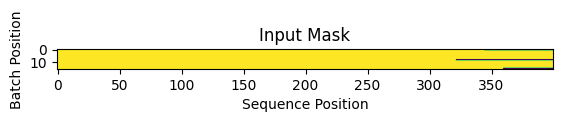

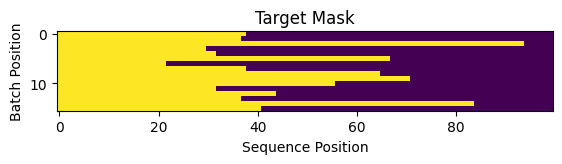

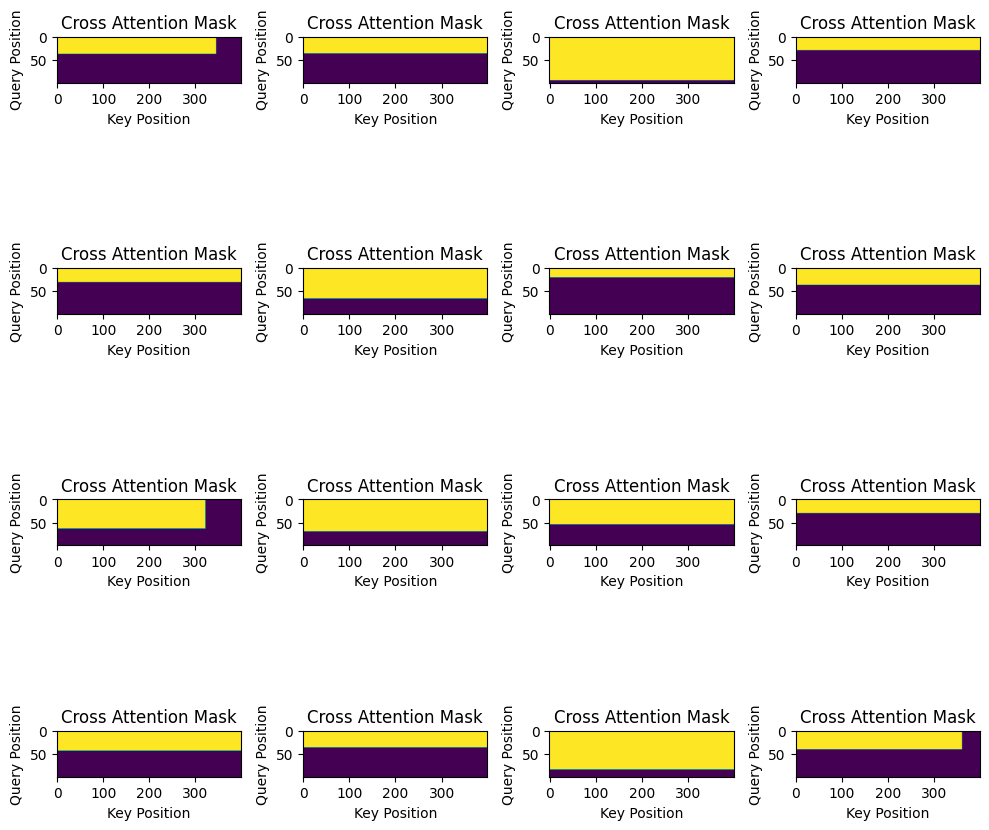

torch.Size([16, 100, 100])


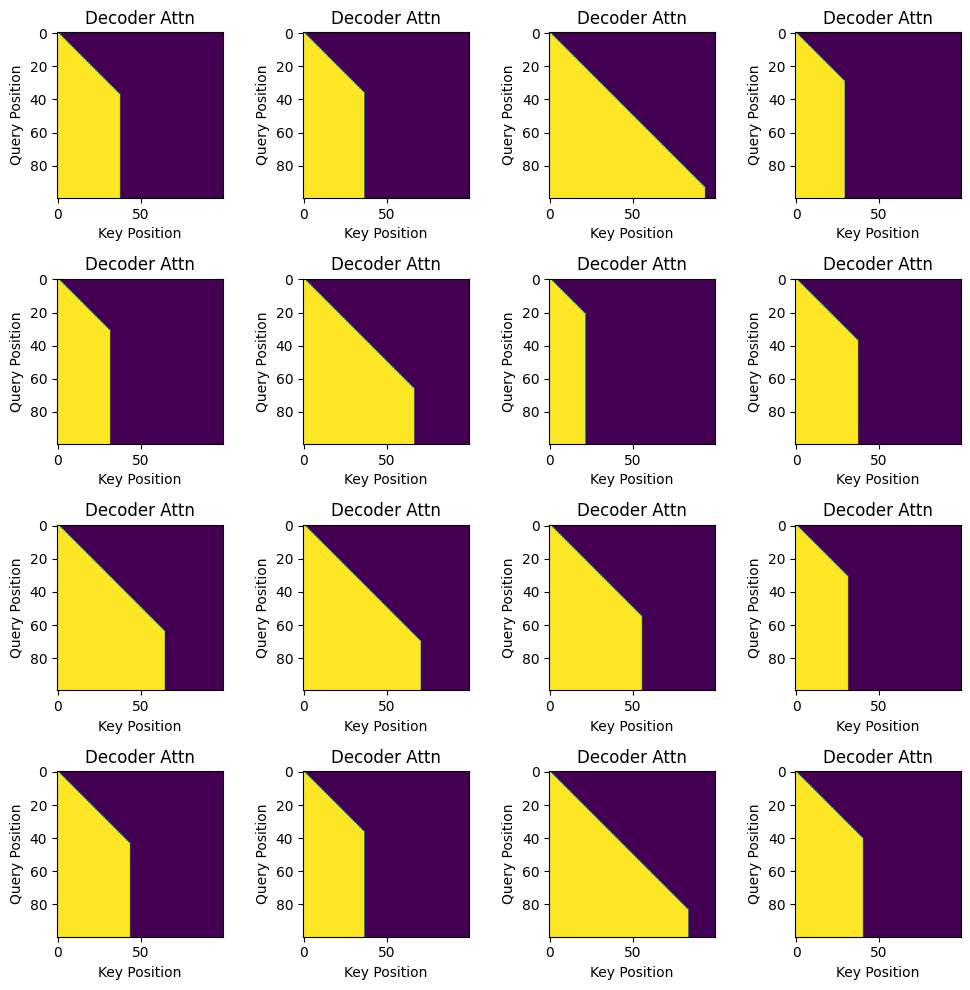

In [54]:
plt.imshow(batch['encoder_mask'].detach().cpu().numpy())
plt.title('Input Mask')
plt.xlabel('Sequence Position')
plt.ylabel('Batch Position')
plt.show()
plt.imshow(batch['decoder_mask'].detach().cpu().numpy())
plt.title('Target Mask')
plt.xlabel('Sequence Position')
plt.ylabel('Batch Position')
plt.show()

# Get the decoder
decoder = trainer.model.decoder
# Encoder and decoder inputs are only used for their shape, so we can create them from zeros
encoder_input = th.zeros(batch_size, ilength, d_model)
decoder_input = th.zeros(batch_size, olength)

import transformer_utils

# This function just tiles the mask to the batch size
encoder_mask = transformer_utils.convert_to_attention_mask(batch['source_sequence'], batch['encoder_mask'])
decoder_mask = transformer_utils.convert_to_attention_mask(batch['target_sequence'], batch['decoder_mask'])

# Call the get_cross_attention_mask function
mask = decoder.get_cross_attention_mask(encoder_input, decoder_input, encoder_mask, decoder_mask)
# Plot the 16 masks in a 4x4 grid
figs, axes = plt.subplots(4,4,figsize=(10,10))
for i in range(16):
    axes[i//4,i%4].imshow(mask[i].detach().cpu().numpy())
    axes[i//4,i%4].set_title('Cross Attention Mask')
    axes[i//4,i%4].set_xlabel('Key Position')
    axes[i//4,i%4].set_ylabel('Query Position')
# legend, axes, labels
figs.tight_layout()
plt.show()

self_attention_mask = decoder.get_self_attention_mask(batch_size, olength, decoder_mask, mask_future=True)
print(self_attention_mask.shape)
# Plot the 16 masks in a 4x4 grid
figs, axes = plt.subplots(4,4,figsize=(10,10))
for i in range(16):
    axes[i//4,i%4].imshow(self_attention_mask[i].detach().cpu().numpy())
    axes[i//4,i%4].set_title('Decoder Attn')
    axes[i//4,i%4].set_xlabel('Key Position')
    axes[i//4,i%4].set_ylabel('Query Position')
figs.tight_layout()
plt.show()


# Using the Summarization model

Now that you have trained a Transformer to perform Summarization, we will use the model on news articles from the wild.

The three subsections below explore what the model has learned.

## The validation loss

We evaluate the model by measuring the cross-entropy loss of the true summaries on a held-out validation set. This part could be used in deciding what is a likely, vs. unlikely summary for an article.

The autograder will run this code on an unreleased test-set to evaluate your model.

In [55]:
gc.collect()
model_id = "test1"
save_dict = th.load(root_folder+'models/summarization/'+f"model_{model_id}.pt", map_location='cpu')
model = Transformer(**save_dict['kwargs'])
model.load_state_dict(save_dict['model_state_dict'])
trainer.model = model.eval()
trainer.to(device)

TransformerTrainer(
  (model): Transformer(
    (encoder): TransformerEncoder(
      (embedding_layer): TransformerInputEmbedding(
        (embedding): Embedding(10000, 160)
        (position_encoding): PositionEmbedding()
        (dropout): Dropout(p=0, inplace=False)
      )
      (encoder0): TransformerEncoderBlock(
        (norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttention(
          (attention_layer): MultiHeadProjection(
            (attention_map): AttentionQKV(
              (apply_mask): ApplyAttentionMask()
            )
          )
          (query_layer): Linear(in_features=160, out_features=160, bias=False)
          (key_layer): Linear(in_features=160, out_features=160, bias=False)
          (value_layer): Linear(in_features=160, out_features=160, bias=False)
          (output_layer): Linear(in_features=160, out_features=160, bias=False)
        )
        (feed_forward): TransformerFeedForward(
          (norm): Laye

In [56]:
losses = []
for i in tqdm(range(100)):
    batch = build_batch(d_valid, 1)
    # Build the feed-dict connecting placeholders and mini-batch
    batch_input, batch_input_mask, batch_output, batch_output_mask = [th.tensor(tensor) for tensor in batch]
    batch_input, batch_input_mask, batch_output, batch_output_mask \
                = list_to_device([batch_input, batch_input_mask, batch_output, batch_output_mask])
    batch = {'source_sequence': batch_input, 'target_sequence': batch_output,
            'encoder_mask': batch_input_mask, 'decoder_mask': batch_output_mask}
    valid_loss, accuracy = trainer(batch,optimize=False)
    losses.append(float(valid_loss.cpu().item()))
print("Validation loss:", np.mean(losses))

100%|██████████| 100/100 [00:03<00:00, 29.75it/s]

Validation loss: 4.179320495203138


In [57]:
# Your best performing model should go here.
os.makedirs(root_folder+"best_models",exist_ok=True)
best_model_file = root_folder+"best_models/summarization_best_model.pt"
th.save(save_dict,best_model_file)

## Generating an article's summary

This model we have built is meant to be used to generate summaries for new articles we do not have summaries for.
We got a [news article](https://www.chicagotribune.com/news/local/breaking/ct-met-officer-shot-20190309-story.html) from the Chicago Tribune about a police shooting, and want to use our model to produce a summary.

As you will see, our model is still limited in its ability, and will most likely not produce an interpretible summary, however, with more data and training, this model would be able to produce good summaries.

If you see upward arrows in the summary, these mean that the following character should be capitalized.

(f) How would you modify the summary sampling procedure if you wanted to generate multiple summaries per article rather than just one?

In [58]:
article_text = "A 34-year-old Chicago police officer has been shot in the shoulder during the execution of a search warrant in the Humboldt Park neighborhood, police say. The alleged shooter, a 19-year-old woman, was in custody. The shooting happened about 7:20 p.m. in the 2700 block of West Potomac Avenue, police said. The officer, part of the Grand Central District tactical unit, was taken to Stroger Hospital. While officers were serving a \"typical\" search warrant for \"narcotics and illegal weapons\" and were attempting to reach a rear door, \"a shot was fired,\" striking the tactical officer in the shoulder, said Chicago police Superintendent Eddie Johnson during a news briefing outside the hospital. He said the officer, who has about four or five years on the job, was \"stable\" but in critical condition. \"His family is here,\" Johnson said. \"He’s talking a lot and just wants the ordeal to be over.\" He said this incident serves as just another reminder of how dangerous a police officer’s job is. At the scene of the shooting, crime tape closed Potomac from Washtenaw Avenue to California Avenue and encompassed the alley west of the brick apartment building, south of Potomac. Dozens of officers stood in the alley, while even more walked up and down the street. Neighbors gathered at the edge of the yellow tape on the sidewalk along California and watched them work. Standing next to a man, a woman talked to police in the crime scene, across the street. \"We're not under arrest? We can go?\" the woman checked with officers. They told her she could go, and she and the man walked underneath the yellow tape and out of the crime scene."
input_length = 400
output_length = 100

# Process the capitalization with the preprocess_capitalization of the capita package.
article_text = capita.preprocess_capitalization(article_text)

# Numerize the tokens of the processed text using the loaded sentencepiece model.
numerized = sp.EncodeAsIds(article_text)
# Pad the sequence and keep the mask of the input
padded, mask = pad_sequence(numerized, pad_index, input_length)

# Making the news article into a batch of size one, to be fed to the neural network.
encoder_input = np.array([padded])
encoder_mask = np.array([mask])

decoded_so_far = [0]

for j in range(output_length):
    padded_decoder_input, decoder_mask = pad_sequence(decoded_so_far, pad_index, output_length)
    padded_decoder_input = [padded_decoder_input]
    decoder_mask = [decoder_mask]
    print("========================")
    print(padded_decoder_input)
    # Use the model to find the distribution over the vocabulary for the next word
    batch = (encoder_input,encoder_mask,padded_decoder_input,decoder_mask)
    batch_input, batch_input_mask, batch_output, batch_output_mask = [th.tensor(tensor) for tensor in batch]
    batch_input, batch_input_mask, batch_output, batch_output_mask \
                = list_to_device([batch_input, batch_input_mask, batch_output, batch_output_mask])
    batch = {'source_sequence': batch_input, 'target_sequence': batch_output,
            'encoder_mask': batch_input_mask, 'decoder_mask': batch_output_mask}
    logits = trainer.model(**batch).cpu().detach().numpy()

    chosen_words = np.argmax(logits, axis=2) # Take the argmax, getting the most likely next word
    decoded_so_far.append(int(chosen_words[0, j])) # We add it to the summary so far


print("The final summary:")
print("".join([vocab[i] for i in decoded_so_far]).replace("▁", " "))

[[0, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998]]
[[0, 3, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 99

## (7) Train a Random Kernel Transformer Model

In Problem 3 on this homework assignment, you show how transformers which use a random kernel approximation to softmax attention can be more efficient than the standard softmax attention. One recent paper which implemented this, Performer (https://arxiv.org/abs/2009.14794), has been implemented below. 

In [61]:


batch_size = 2
vocab_size = 11
n_layers = 3
n_heads = 4
d_model = 8
d_filter = 16
input_length = 5
output_length = 3
max_seq_len = 10

torch.manual_seed(1)
random.seed(1)

performer = PerformerEncDec(num_tokens=vocab_size, max_seq_len=max_seq_len, depth=n_layers, heads=n_heads, dim=d_model, ff_mult=d_filter//d_model, dim_head=d_model//n_heads, feature_redraw_interval=10000)
performer = th.load(root_folder+"transformer_checks/performer")

with open(root_folder+"transformer_checks/performer_io_new.json", "r") as f:
    io = json.load(f)
    enc_input = th.tensor(io['enc_input'])
    dec_input = th.tensor(io['dec_input'])
    enc_mask = th.tensor(io['enc_mask'])
    dec_mask = th.tensor(io['dec_mask'])
    expected_output = th.tensor(io['output'])
    projection_matrix = th.tensor(io['projection_matrix'])

for n, m in performer.named_modules():
    if isinstance(m, FastAttention):
        m.projection_matrix.data = projection_matrix.data

# transformer.load_state_dict(th.load(root_folder+"transformer_checks/transformer"))
(enc_input,dec_input,enc_mask,dec_mask,expected_output,performer) \
    = list_to_device((enc_input,dec_input,enc_mask,dec_mask,expected_output,performer))
_, output_t = performer(enc_input, target_sequence=dec_input, encoder_mask=enc_mask, decoder_mask=dec_mask)

validate_to_array(model_out_to_list, ((enc_input, dec_input, enc_mask, dec_mask), performer),'performer', root_folder)
    
print("Total error on the output:",th.sum(th.abs(expected_output-output_t)).item(), "(should be 0.0 or close to 0.0)")


{'num_tokens': 11, 'max_seq_len': 10, 'depth': 3, 'heads': 4, 'ff_mult': 2, 'dim_head': 2, 'feature_redraw_interval': 10000} {'num_tokens': 11, 'max_seq_len': 10, 'depth': 3, 'heads': 4, 'ff_mult': 2, 'dim_head': 2, 'feature_redraw_interval': 10000}
unable to import cuda code for auto-regressive Performer. will default to the memory inefficient non-cuda version
unable to import cuda code for auto-regressive Performer. will default to the memory inefficient non-cuda version
unable to import cuda code for auto-regressive Performer. will default to the memory inefficient non-cuda version


AttributeError: 'GELU' object has no attribute 'approximate'

In [62]:
# Dataset related parameters
vocab_size = len(vocab)
ilength = 400 # Length of the article
olength  = 100 # Length of the summaries

# Model related parameters, feel free to modify these.
n_layers = 6
d_model  = 160
d_filter = 4*d_model
batch_size = 16

dropout = 0
learning_rate = 1e-3
trainer = TransformerTrainer(vocab_size, d_model, ilength, olength, n_layers, d_filter, dropout, performer=True)
model_id = 'test1—performer'
os.makedirs(root_folder+'models/part2/',exist_ok=True)

# Skeleton code, as in the previous notebook.
# Write code training code and save your best performing model on the
# validation set. We will be testing the loss on a held-out test dataset.
from curses import init_pair
from tqdm import tqdm

trainer.to(device)
trainer.model.train()
losses,accuracies = [],[]
t = tqdm(range(int(1e3)+1))
for i in t:
    # Create a random mini-batch from the training dataset
    batch = build_batch(d_train, batch_size)
    # Build the feed-dict connecting placeholders and mini-batch
    batch_input, batch_input_mask, batch_output, batch_output_mask = [th.tensor(tensor) for tensor in batch]
    batch_input, batch_input_mask, batch_output, batch_output_mask \
                = list_to_device([batch_input, batch_input_mask, batch_output, batch_output_mask])
    batch = {'source_sequence': batch_input, 'target_sequence': batch_output,
            'encoder_mask': batch_input_mask, 'decoder_mask': batch_output_mask}

    # Obtain the loss. Be careful when you use the train_op and not, as previously.
    train_loss, accuracy = trainer(batch)
    losses.append(train_loss.item()),accuracies.append(accuracy.item())
    if i % 10 == 0:
        t.set_description(f"Iteration: {i} Loss: {np.mean(losses[-10:])} Accuracy: {np.mean(accuracies[-10:])}")
    if i % 100 == 0:
        save_dict = dict(
            kwargs = dict(
                num_tokens=vocab_size,
                max_seq_len=max(input_length, output_length), 
                depth=n_layers, 
                heads=n_heads, 
                dim=d_model, 
                ff_mult=d_filter//d_model, 
                dim_head=d_model//n_heads
            ),
            model_state_dict = trainer.model.state_dict(),
            notes = ""
        )
        th.save(save_dict, root_folder+f'models/part2/model_{model_id}.pt')

{'num_tokens': 10000, 'max_seq_len': 400, 'depth': 6, 'heads': 4, 'ff_mult': 4, 'dim_head': 40} {'num_tokens': 10000, 'max_seq_len': 400, 'depth': 6, 'heads': 4, 'ff_mult': 4, 'dim_head': 40}
unable to import cuda code for auto-regressive Performer. will default to the memory inefficient non-cuda version
unable to import cuda code for auto-regressive Performer. will default to the memory inefficient non-cuda version
unable to import cuda code for auto-regressive Performer. will default to the memory inefficient non-cuda version
unable to import cuda code for auto-regressive Performer. will default to the memory inefficient non-cuda version
unable to import cuda code for auto-regressive Performer. will default to the memory inefficient non-cuda version
unable to import cuda code for auto-regressive Performer. will default to the memory inefficient non-cuda version


Iteration: 30 Loss: 3.475075531005859 Accuracy: 0.1989635095000267:   3%|▎         | 33/1001 [00:21<10:27,  1.54it/s] 


KeyboardInterrupt: 

# Submission Instructions

When you are done, please run collect_submission.sh and upload the generated assignment8.zip *.py file to the coding assignment on gradescope.